# Rates of Covid19 in Madrid
> Initial exploration of infection data

- toc: true
- badges: true
- comments: true
- categories: [Madrid, Covid19]
- image: images/rates-preview.png


In [1]:
#hide
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [37]:
#collapse-hide
!pip install geopandas

import pandas as pd
import numpy as np
import re

import geopandas
import plotnine
from plotnine import *

import matplotlib.pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import confusion_matrix

%matplotlib inline

## Covid19 Weekly Data from the 'Comunidad de Madrid'

https://datos.comunidad.madrid/catalogo/dataset/covid19_tia_zonas_basicas_salud

### Covid 19-TIA Zonas Básicas de Salud (CSV)

On a Tuesday morning, weekly data are provided for the 286 basic health areas:
 - confirmed cases and rate of accumulated incidence for basic health areas
 - the source of data is the Madrid region's network of epidemiological vigilence
 - the data are continually updated; you should always show the date when the data were accessed
 - the polygon data includes the population figures from the region's statistical institute from the population register of 1 January 2019.

"Información epidemiológica Covid-19: Casos confirmados y tasa de incidencia acumulada (TIA) por Zonas Básicas de Salud (Decreto 52/2010, de 29 de julio, BOCM 9 de agosto de 2010).
Informe diario o semanal con datos de casos confirmados, casos confirmados con infección activa y tasas de incidencia acumulada de los últimos 14 días y desde el inicio de la epidemia (25 de febrero de 2020).
La fuente de los datos es la Red de Vigilancia Epidemiológica de la Comunidad de Madrid. Cuando se utilicen los datos se debe indicar en qué fecha se ha accedido a los mismos, dada su actualización continua.
Hasta el 1 de julio de 2020 los registros de datos correspondientes a cada fecha de informe se han añadido diariamente. A partir del 2 de julio de 2020 la actualización pasa a ser semanal.
A fecha 1 de junio, se ha procedido a actualizar el conjunto de datos de Zonas Básicas de Salud, con los datos actualizados de geometrías proporcionados por el Instituto de Estadística de la Comunidad de Madrid. Las nuevas geometrías incluyen los datos poblacionales actualizados por el Instituto de Estadística de la Comunidad de Madrid, relativos al Padrón Continuo a 1 de enero de 2019."

Here we will read the CSV data dated 29 September 2020 and explore:

In [3]:
zones_df=pd.read_csv('covid19_tia_zonas_basicas_salud_s.csv', delimiter=';', encoding='latin')

In [4]:
#collapse-hide
print ('Columns:')
[print(col) for col in list(zones_df.columns)]
print()
print('Shape: ',zones_df.shape)
print()
print('Dates: ',list(zones_df.fecha_informe.unique()))

Columns:
zona_basica_salud
fecha_informe
casos_confirmados_activos_ultimos_14dias
tasa_incidencia_acumulada_activos_ultimos_14dias
casos_confirmados_ultimos_14dias
tasa_incidencia_acumulada_ultimos_14dias
casos_confirmados_totales
tasa_incidencia_acumulada_total
codigo_geometria

Shape:  (5434, 9)

Dates:  ['2020/09/29 11:15:00', '2020/09/22 09:42:00', '2020/09/15 10:23:00', '2020/09/08 11:03:00', '2020/09/01 09:33:00', '2020/08/25 09:33:00', '2020/08/18 09:32:00', '2020/08/11 09:31:00', '2020/08/04 09:58:00', '2020/07/28 09:34:00', '2020/07/21 09:23:00', '2020/07/14 09:23:00', '2020/07/07 09:32:00', '2020/06/30 07:00:00', '2020/06/23 07:00:00', '2020/06/16 07:00:00', '2020/06/09 07:00:00', '2020/06/02 07:00:00', '2020/05/26 07:00:00']


Tidy-up the dataframe by
 - replacing decimal `,` with decimal `.`
 - shortening key column names
 - dropping time from the date column

In [5]:
for col in ['tasa_incidencia_acumulada_activos_ultimos_14dias', 'tasa_incidencia_acumulada_ultimos_14dias', 'tasa_incidencia_acumulada_total']:
    zones_df[col] = pd.to_numeric(zones_df[col].apply(lambda x: re.sub(',', '.', x)))
zones_df.rename(columns={'zona_basica_salud':'zona_basic','tasa_incidencia_acumulada_ultimos_14dias':'tasa', 'casos_confirmados_ultimos_14dias':'casos'}, inplace=True)
zones_df.fecha_informe=zones_df.fecha_informe.apply(lambda x: x[5:10])

Data for the centre of Madrid (where the main office of the regional authority are located).

In [6]:
zones_df[zones_df.zona_basic=='Cortes'].T

,60,346,632,918,1204,1490,1776,2062,2348,2651,2920,3206,3492,3778,4064,4350,4636,4922,5208
zona_basic,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes,Cortes
fecha_informe,09/29,09/22,09/15,09/08,09/01,08/25,08/18,08/11,08/04,07/28,07/21,07/14,07/07,06/30,06/23,06/16,06/09,06/02,05/26
casos_confirmados_activos_ultimos_14dias,49,67,18,17,14,17,33,15,19,10,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN
tasa_incidencia_acumulada_activos_ultimos_14dias,185.94,254.25,68.31,64.51,53.13,64.51,125.23,56.92,72.1,37.95,18.97,15.18,3.79,3.79,18.97,26.56,15.18,3.79,3.79
casos,203,188,188,169,147,89,64,49,27,19,7,NaN,NaN,NaN,8,10,10,7,NaN
tasa,770.34,713.42,713.42,641.32,557.83,337.74,242.87,185.94,102.46,72.1,26.56,18.97,7.59,11.38,30.36,37.95,37.95,26.56,15.18
casos_confirmados_totales,939,820,713,613,522,429,365,332,293,281,264,261,251,246,245,242,236,231,226
tasa_incidencia_acumulada_total,3563.3,3111.72,2705.68,2326.2,1980.87,1627.96,1385.09,1259.87,1111.87,1066.33,1001.82,990.44,952.49,933.52,929.72,918.34,895.57,876.59,857.62
codigo_geometria,061,061,061,061,061,061,061,061,061,,061,061,061,061,061,061,061,061,061


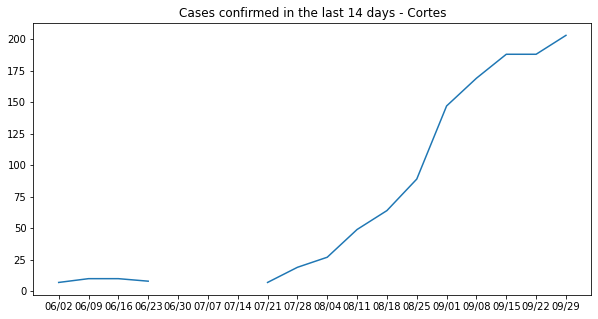

In [7]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(zones_df[zones_df.zona_basic=='Cortes'].fecha_informe[::-1], zones_df[zones_df.zona_basic=='Cortes'].casos[::-1])
plt.title('Cases confirmed in the last 14 days - Cortes');

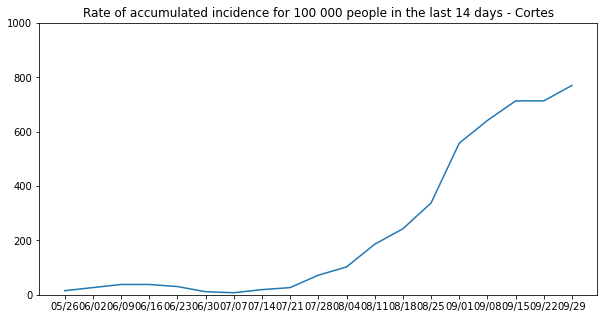

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(zones_df[zones_df.zona_basic=='Cortes'].fecha_informe[::-1], zones_df[zones_df.zona_basic=='Cortes'].tasa[::-1])
plt.ylim(0,1000)
plt.title('Rate of accumulated incidence for 100 000 people in the last 14 days - Cortes');

In [9]:
print(len(zones_df.zona_basic.unique()))
print(zones_df.zona_basic.unique()[:10])

286
['Abrantes' 'Acacias' 'Adelfas' 'Alameda' 'Alameda de Osuna'
 'Alcalde Bartolomé González' 'Alcalá de Guadaira' 'Alcobendas - Chopera'
 'Alcocer' 'Algete']


Allocate to bins based on rate

In [10]:
zones_df.tasa.fillna(0, inplace=True)
cut_labels=['<200','200-400','400-600','600-800','800-1000','>1000']
cut_bins = [-1., 200., 400., 600., 800., 1000., max(zones_df.tasa)]
zones_df['tasa_bin'] = pd.cut(zones_df.tasa, bins=cut_bins, labels=cut_labels)
zones_df.tasa_bin.value_counts()

<200        3667
200-400      654
400-600      475
600-800      301
>1000        175
800-1000     162
Name: tasa_bin, dtype: int64

Helper function to check for errors in the presentation of the names, e.g. spaces, 'de',...

In [11]:
#collapse-hide
def check_zones(zonas_restricted):
  lst=[]
  for zona_basic in zones_df.zona_basic[:286]:
    if zona_basic in zonas_restricted: lst.append(zona_basic)
  print(len(lst), set(zonas_restricted)-set(lst))

Identify the initial 37 areas restricted from 21 September 2020:

In [12]:
zonas_restricted_1=["Puerta Bonita","Vista Alegre","Guayaba", "Almendrales", "Las Calesas", "Zofío", "Orcasur", "San Fermín", "San Andrés", "San Cristóbal", 
                  "El Espinillo", "Los Rosales", "Villa Vallecas", "Entrevías", "Martínez de la Riva", "San Diego",
                  "Numancia", "Peña Prieta", "Pozo de Tío Raimundo", "Ángela Uriarte", "Alcalá de Guadaira", "Federica Montseny", "Doctor Cirajas", 
                  "Gandhi", "Daroca", "La Elipa", "Alicante", "Cuzco", "Francia", "Humanes de Madrid", "San Blas", "Isabel II",
                  "Las Margaritas", "Sánchez Morate", "Reyes Católicos", "Alcobendas - Chopera", "Miraflores"]

check_zones(zonas_restricted_1)

37 set()


Identify the additional 8 areas restricted from 28 September 2020:

In [13]:
zonas_restricted_2=["Panaderas", "Doctor Trueta", "Miguel Servet", "Campo de la Paloma", "Rafael Alberti", "García Noblejas", "Vicálvaro - Artilleros","Orcasitas"]

check_zones(zonas_restricted_2)

8 set()


Label zones with restricted group

In [14]:
zones_df['restricted']='0'
for i in range(len(zonas_restricted_1)): zones_df.loc[zones_df.zona_basic==zonas_restricted_1[i], 'restricted']='1'
for i in range(len(zonas_restricted_2)): zones_df.loc[zones_df.zona_basic==zonas_restricted_2[i], 'restricted']='2'
zones_df.restricted.value_counts()/len(zones_df.fecha_informe.unique())

0    241.0
1     37.0
2      8.0
Name: restricted, dtype: float64

Helper function to reorder the presentation of the dates

In [15]:
#collapse-hide
def col_func(fecha): return fecha[3]+fecha[4]+fecha[2]+fecha[0]+fecha[1]

### Histograms of number of zones in each category in the last 6 weeks

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


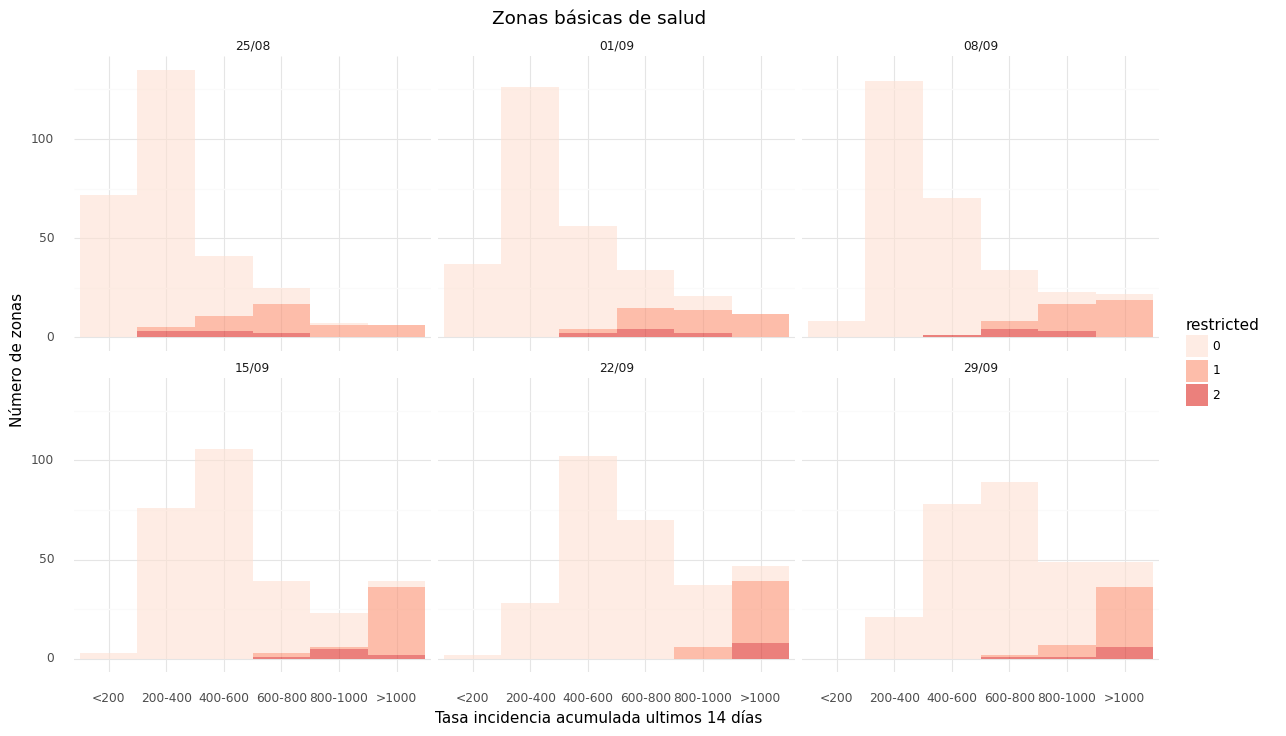

<ggplot: (-9223363251790041782)>

In [38]:
plotnine.options.figure_size = (14, 8)

ggplot(zones_df[zones_df.fecha_informe>'08/24'], aes(x='tasa_bin', fill='restricted')) \
+ geom_histogram(binwidth=1, alpha=0.6, position='stack') \
+ facet_wrap('fecha_informe', labeller=labeller(cols=col_func)) \
+ theme_minimal() \
+ labs(title="Zonas básicas de salud",
       x='Tasa incidencia acumulada ultimos 14 días',
       y="Número de zonas") \
+ scale_fill_brewer(palette = 'Reds')

### Maps for the most recent week

In [17]:
week_df=zones_df[zones_df.fecha_informe==zones_df.fecha_informe.unique().max()][['zona_basic','tasa','casos','tasa_bin','restricted']]
df=(geopandas.read_file('./maps/zonas_basicas_salud.shp')).merge(week_df)
df['geometry_pt']=df.geometry.centroid
df.head().T

,0,1,2,3,4
codigo_geo,001,002,003,004,005
pob_pad19,30748,19432,29168,21274,29001
zona_basic,Abrantes,Acacias,Adelfas,Alameda,Alameda de Osuna
geometry,"POLYGON ((439068.7580000004 4470731.660800001,...","POLYGON ((439924.9298999999 4472798.281400001,...","POLYGON ((443455.7175000003 4472836.7236, 4434...","POLYGON ((440659.7537000002 4473778.4014, 4406...","POLYGON ((452408.1383999996 4484644.699999999,..."
tasa,913.88,504.32,551.97,766.19,610.32
casos,281,98,161,163,177
tasa_bin,800-1000,400-600,400-600,600-800,600-800
restricted,0,0,0,0,0
geometry_pt,POINT (438360.9828817752 4470073.107306919),POINT (439858.3553289876 4472447.600519221),POINT (442903.0377880885 4472532.970746173),POINT (440836.3215957115 4473539.390589811),POINT (451700.7212964218 4480650.657189403)


Maps of rate of accumulated instance and restricted zones

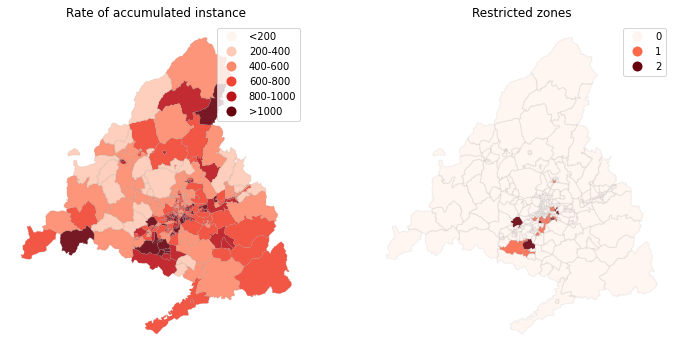

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,6))

df.plot(ax=ax1, column=df.tasa_bin, cmap='Reds', legend=True)
df.plot(ax=ax1, color='white', edgecolor='grey', alpha=0.1)
ax1.set_title('Rate of accumulated instance')
ax1.axis('off')

df.plot(ax=ax2, column=df.restricted, cmap='Reds', legend=True)
df.plot(ax=ax2, color='white', edgecolor='grey', alpha=0.1)
ax2.set_title('Restricted zones')
ax2.axis('off');

In [19]:
df.tasa_bin.value_counts()

600-800     89
400-600     78
>1000       49
800-1000    49
200-400     21
<200         0
Name: tasa_bin, dtype: int64

In [20]:
df.restricted.value_counts()

0    241
1     37
2      8
Name: restricted, dtype: int64

### Treating the rate as a surface and plotting contours
Linear interpolation of the rate at the centroid of each zone

In [21]:
def getXY(pt): return (pt.x, pt.y)

In [22]:
def data_for_week(fecha):
  week_df=zones_df[zones_df.fecha_informe==fecha][['zona_basic','tasa','casos','tasa_bin','restricted']]
  df=geopandas.read_file('./maps/zonas_basicas_salud.shp').merge(week_df)
  x, y = [list(t) for t in zip(*map(getXY, df.geometry.centroid))]
  z = df.tasa
  return x,y,z

In [23]:
def multi_plot(i):

    fecha=weeks[i]
    x,y,z = data_for_week(fecha)

    fig, ax = plt.subplots(1,1,figsize=(10,8))
    ax.set(xlim=(360000, 500000), ylim=(4420000, 4550000))
    
    cntr = ax.tricontourf(x, y, z, [0,200,400,800,1000,2000], cmap="Reds") # plot contour fill
    df.plot(color='white', edgecolor='grey', alpha=0.1, ax=ax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.0)

    fig.colorbar(cntr, drawedges=False, cax=cax)
    ax.set_title(f'Tasa incidencia acumulada en los últimos 14 días\n fecha {fecha[3]+fecha[4]+fecha[2]+fecha[0]+fecha[1]}, maximum {str(int(max(z)))}/100000 habitantes')
    ax.axis('off')

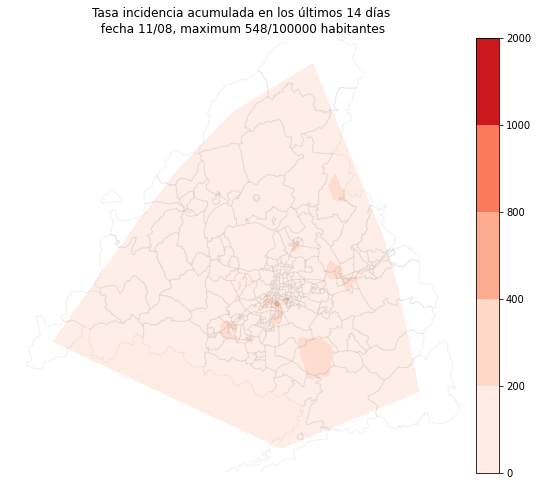

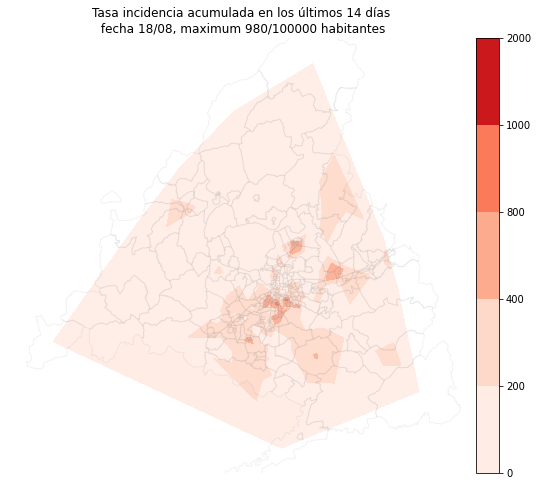

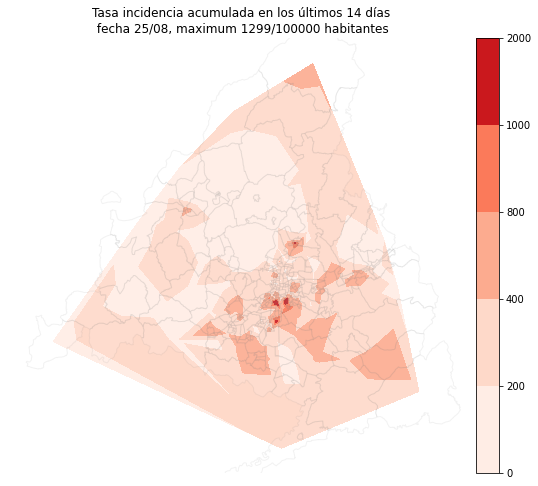

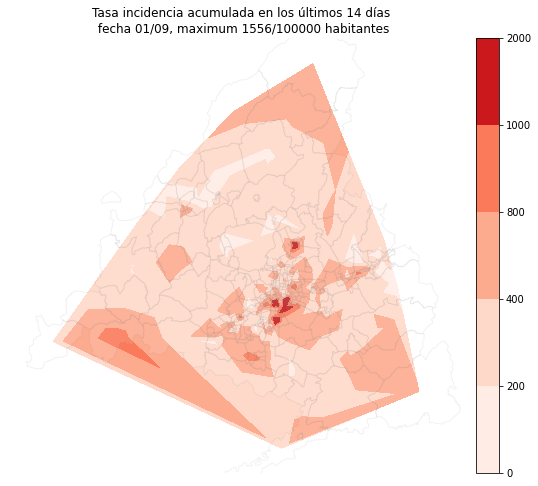

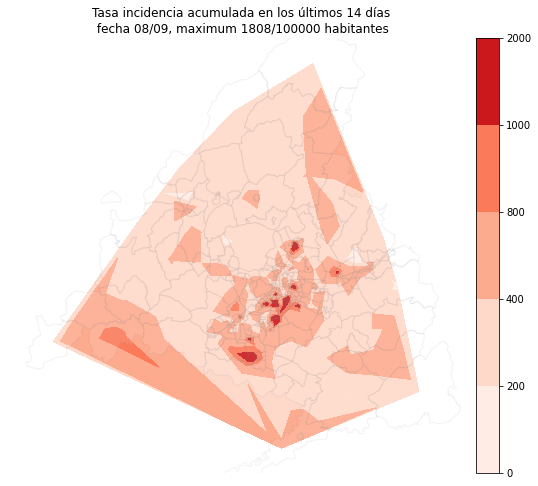

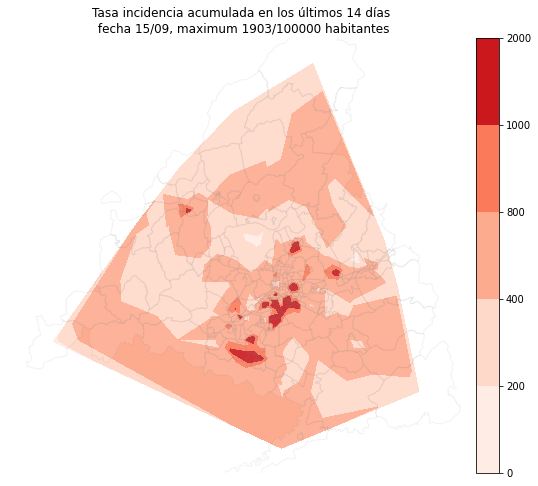

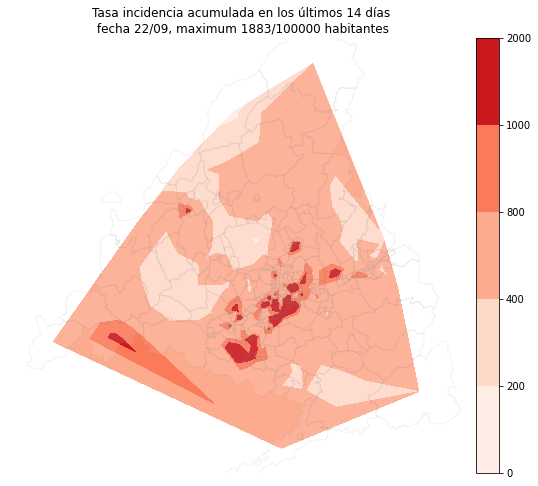

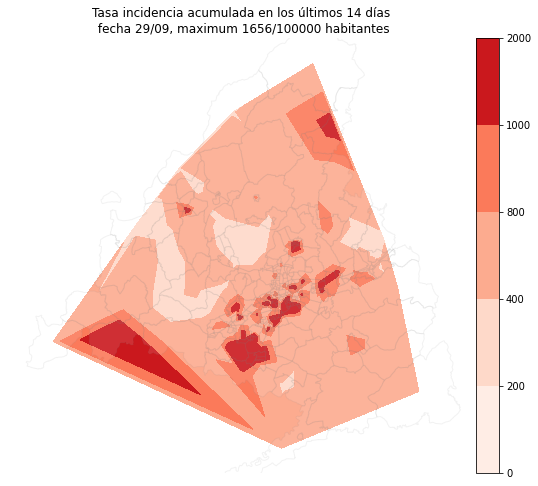

In [24]:
weeks = zones_df.fecha_informe.unique()[:8][::-1] 
for i in range(len(weeks)): multi_plot(i)

Plots for 4 weeks

In [25]:
#collapse-hide
def plot_4_weeks(plot_weeks):
  fig, axs = plt.subplots(1, 4, figsize=(16, 4))
  for i in range(4):
    fecha=plot_weeks[i]
    x,y,z = data_for_week(plot_weeks[i])
    df.plot(color='white', edgecolor='grey', alpha=0.1, ax=axs[i])
    axs[i].set_title(f'\nfecha {fecha[3]+fecha[4]+fecha[2]+fecha[0]+fecha[1]}\nmax. {str(int(max(z)))}/100000 hab.', fontsize=8)
    axs[i].axis('off')
    cntr=axs[i].tricontourf(x,y,z,[0,200,400,800,1000,2000], cmap="Reds")

  divider = make_axes_locatable(axs[-1])
  cax = divider.append_axes("right", size="3%", pad=0.0)
  fig.colorbar(cntr, drawedges=False, cax=cax)
  fig.suptitle('Tasa incidencia acumulada en los últimos 14 días', fontsize=12, va='baseline')
  plt.savefig('four_weeks.png', bbox_inches='tight');

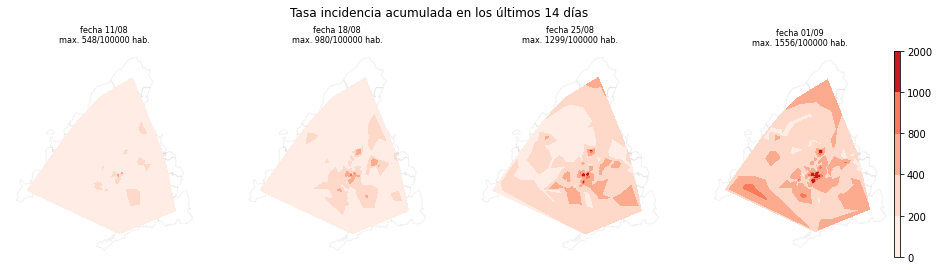

In [26]:
plot_4_weeks(weeks[:4])

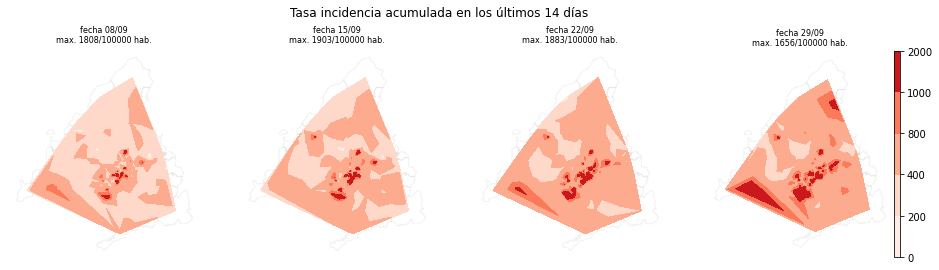

In [27]:
plot_4_weeks(weeks[4:])

### Confusion matrix for rate > 1000 and restrictions

In [28]:
week_df=zones_df[zones_df.fecha_informe==zones_df.fecha_informe.max()][['zona_basic','tasa','casos','tasa_bin','restricted']]
df=(geopandas.read_file('./maps/zonas_basicas_salud.shp')).merge(week_df)
print(confusion_matrix((df.restricted != '0')*1, (df.tasa>1000)*1))

[[228  13]
 [  9  36]]


 - 228 zones with rate less than 1000 and no restrictions.
 - 36 zones with rate over 1000 and restrictions.

13 zones with rate over 1000 but no restrictions

In [31]:
df[(df.restricted == '0') & (df.tasa>1000)].sort_values('tasa', ascending=False).zona_basic.to_list()

['Villa del Prado',
 'Pintores',
 'Comillas',
 'Sierra de Guadarrama',
 'El Naranjo',
 'San Isidro',
 'Torrelaguna',
 'Ciudad San Pablo',
 'Valleaguado',
 'Las Fronteras',
 'Canillejas',
 'Antonio Leyva',
 'María Curie']

9 zones with rate under 1000 but restricted

In [30]:
df[(df.restricted != '0') & (df.tasa<1000)].sort_values('tasa', ascending=False).zona_basic.to_list()

['Daroca',
 'Sánchez Morate',
 'Federica Montseny',
 'Guayaba',
 'García Noblejas',
 'Orcasur',
 'El Espinillo',
 'Orcasitas',
 'San Fermín']

### Comparison of individual zones to the best and worst

In [34]:
df_tmp=zones_df[zones_df.fecha_informe==zones_df.fecha_informe.max()]
most = df_tmp[df_tmp.tasa==df_tmp.tasa.max()].zona_basic.to_list()[0]
least = df_tmp[df_tmp.tasa==df_tmp.tasa.min()].zona_basic.to_list()[0]
most, least

('Alicante', 'El Pardo')

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


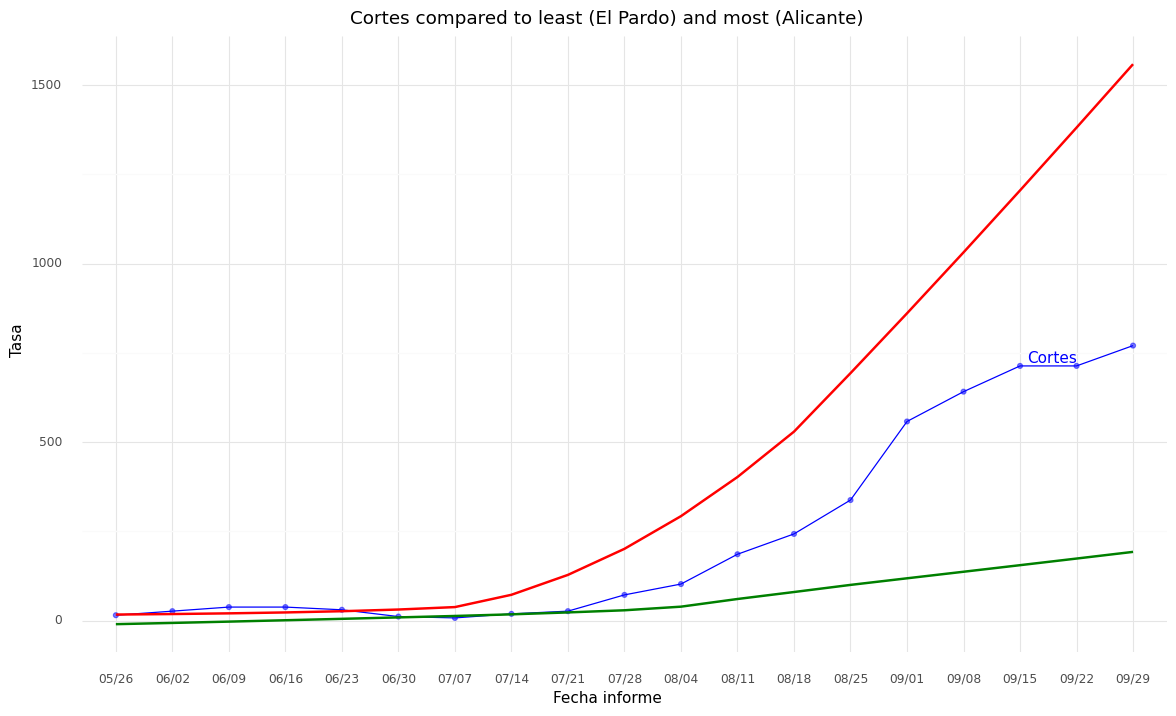

<ggplot: (-9223363251787262930)>

In [39]:
zona = 'Cortes'

df_tmp = zones_df.pivot_table(values='tasa', index='fecha_informe', columns='zona_basic').reset_index()
zbs = [most, zona, least]
title= zbs[1] + ' compared to least (' + zbs[2] + ') and most (' + zbs[0] + ')'
ggplot(df_tmp, aes(x='fecha_informe',y=zbs[1],group=1)) \
  + geom_point(colour='blue', alpha = 0.5) \
  + geom_line(aes(y=zbs[1]), colour='blue') \
  + geom_smooth(aes(y=zbs[0]), colour='red' ) \
  + geom_smooth(aes(y=zbs[2]), colour='green') \
  + labs(title=title,
         x='Fecha informe',
         y="Tasa") \
  + geom_text(data=df_tmp[df_tmp.fecha_informe=='09/22'],label=zbs[1], color='blue', hjust= 'right', vjust='bottom') \
  + theme_minimal()